# Тестовое задание

Для выполнения тестового задания требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей.
Для обучения модели используйте данные из файла `train.tsv`. В файле находится таблица, состоящая из двух колонок. 
В колонке title записан заголовок новости. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная.
Для демонстрации работы модели используйте данные тестового набора из файла `test.tsv`. В нем также есть колонка title, данные которой являются входными для вашей модели.
Вам нужно скопировать файл `test.tsv`, переименовать его в `predictions.tsv` и заполнить колонку is_fake значениями предсказаний вашей модели, аналогично `train.tsv`. 
Изначально колонка заполнена значением 0.

# Критерии оценки
1. Для оценки финального решения будет использоваться метрика F1 score.
2. Чистота кода, оформление и понятность исследования.

# Требования к решению
В качестве решения мы ожидаем zip-архив со всеми *.py и *.ipynb файлами в папке solution и файлом `predictions.tsv` в корне. Формат имени zip-архива: LastName_FirstName.zip (пример Ivanov_Ivan.zip).
Файл `predictions.tsv` должен включать в себя колонку title, содержащую те же данные, что и исходный файл `test.tsv`, а также колонку is_fake, содержащую значения 0 или 1.
Разметка тестового набора данных и включение его в обучение/валидацию запрещены.

В папке solution должно быть отражено исследование и весь код, необходимый для воспроизведения исследования.

Успехов!

In [1]:
! pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from functools import partial
from lightautoml.tasks import Task
from lightautoml.automl.presets.text_presets import TabularNLPAutoML

In [3]:
RANDOM_STATE = 228
TEST_SIZE = 0.3
FOLDS_NUMBER = 5

## EDA

In [4]:
df = pd.read_csv('dataset/train.tsv', sep='\t')
test_df = pd.read_csv('dataset/test.tsv', sep='\t')
df.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [5]:
df.describe()

,is_fake
count,5758.000000
mean,0.500000
std,0.500043
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


### Пропуски

In [6]:
df.isnull().sum()

title      0
is_fake    0
dtype: int64

Пропуски в данных отсутствуют

<AxesSubplot:xlabel='is_fake', ylabel='count'>

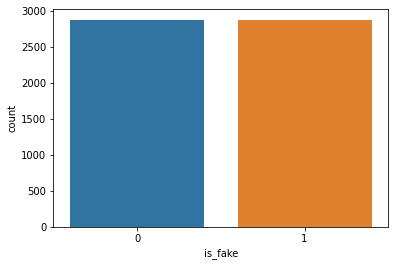

In [7]:
sns.countplot(x ='is_fake', data=df)

### Баланс классов

In [8]:
df['is_fake'].value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

Фейков и не фейков поровну

### Длина заголовка
Рассмотрим данные по длине в символах и словах

In [9]:
df['char_count'] = df['title'].str.len()
df['word_count'] = df['title'].str.split().str.len()

In [10]:
print('Длина самой большой строки в символах:', df['char_count'].max())
print('Длина самой большой строки в словах:', df['word_count'].max())
print('Длина самой маленькой строки в символах:', df['char_count'].min())
print('Длина самой маленькой строки в словах:', df['word_count'].min())

Длина самой большой строки в символах: 211
Длина самой большой строки в словах: 37
Длина самой маленькой строки в символах: 17
Длина самой маленькой строки в словах: 3


Рассмотрим эти крайние случаи

In [11]:
df.nsmallest(10, 'word_count')

,title,is_fake,char_count,word_count
596,Студия-разработчик S.T.A.L.K.E.R. закроется,0,43,3
681,Умерла Татьяна Шмыга,0,20,3
1119,Зенит разгромил Локомотив,0,25,3
1243,Жуки-киборги заменят беспилотники,0,33,3
1415,Итоги года. Наука,1,17,3
1975,Павленского признали вменяемым,0,30,3
2130,Кудрин поможет регионам-середнякам,0,34,3
2702,«АвтоВАЗ» повысил цены,0,22,3
2859,Razer представила мышку-трансформер,0,35,3
3268,Группа Supergrass распалась,0,27,3


In [12]:
df[df['title'].str.contains('Итоги года')]

,title,is_fake,char_count,word_count
261,Итоги года. Хорошие новости,1,27,4
1415,Итоги года. Наука,1,17,3
1473,Итоги года. Сделано у нас,1,25,5
3700,Итоги года. Политика,1,20,3
3841,Итоги года. Регионы,1,19,3
4320,Итоги года. Технологии,1,22,3
4389,Итоги года. Культура,1,20,3
4597,Итоги года. Плохие новости,1,26,4
4755,Итоги года. Россия,1,18,3


Удалим эти случаи, так как они очень неочевидные даже для человека

In [13]:
df = df[~df.title.str.contains("Итоги года")]

In [14]:
df.nlargest(10, 'word_count')

,title,is_fake,char_count,word_count
968,«А что ты обращался к нам с лаем и дальше хоче...,1,211,37
5111,"Американский чемпион-трансэйджер, драка пилото...",1,198,27
5703,"Новые квартиры для ветеранов, туманные перспек...",1,184,26
4213,"Урановые рудники для пенсионеров, электросамок...",1,191,25
5663,"Новые женихи для королевы, западные атаки на Р...",1,172,25
1093,Лукашенко перед вылетом в Сочи призвал не бесп...,1,132,23
1378,"Невезучий псковский математик, новая фабрика м...",1,169,23
2030,"Новый юбилей Горбачёва, лицензии на выгребную ...",1,172,23
3237,"Си Цзиньпин: «Если бы Китай стал частью СССР, ...",1,142,23
3518,Билл Клинтон: «В начале 90-х русские либералы ...,1,151,23


In [15]:
df[df['word_count'] == 27]['title'].iloc[0]

'Американский чемпион-трансэйджер, драка пилотов за место на парковке в Пулково, кокаин на экономическом форуме и почему шелкопряд здешний, а не тутовый в нашей традиционной рубрике «Панорама недели»'

In [16]:
df[df['title'].str.contains('Панорама')]

,title,is_fake,char_count,word_count
325,"Губернатор Моргенштерн, заблокированный Суэцки...",1,188,22
1378,"Невезучий псковский математик, новая фабрика м...",1,169,23
1592,"День космонавтики, Золотое кольцо вместо Турци...",1,137,17
1721,"Новая миссия Сердюкова, новая ведущая детского...",1,154,19
2030,"Новый юбилей Горбачёва, лицензии на выгребную ...",1,172,23
2417,Первая русская газета называлась «Панорама»: И...,1,104,13
2851,В честь 199-летия ИА «Панорама» князь Монако п...,1,92,12
3189,Вехи. От декабристов до Горбачёва: кто и когда...,1,76,12
3613,"Успешная борьба женщин за свои права, новый ко...",1,154,21
4145,"Суд над Навальным, обновлённый Явлинский, адск...",1,121,16


Все заголовки со словом "Панорама" – фейки

In [17]:
df.nlargest(50, 'word_count')

,title,is_fake,char_count,word_count
968,«А что ты обращался к нам с лаем и дальше хоче...,1,211,37
5111,"Американский чемпион-трансэйджер, драка пилото...",1,198,27
5703,"Новые квартиры для ветеранов, туманные перспек...",1,184,26
4213,"Урановые рудники для пенсионеров, электросамок...",1,191,25
5663,"Новые женихи для королевы, западные атаки на Р...",1,172,25
1093,Лукашенко перед вылетом в Сочи призвал не бесп...,1,132,23
1378,"Невезучий псковский математик, новая фабрика м...",1,169,23
2030,"Новый юбилей Горбачёва, лицензии на выгребную ...",1,172,23
3237,"Си Цзиньпин: «Если бы Китай стал частью СССР, ...",1,142,23
3518,Билл Клинтон: «В начале 90-х русские либералы ...,1,151,23


50 самых длинных по словам заголовки – фейки

<AxesSubplot:xlabel='is_fake', ylabel='word_count'>

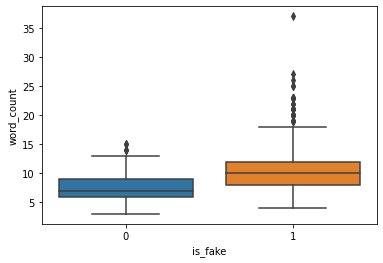

In [18]:
sns.boxplot(x='is_fake', y='word_count', data=df)

In [19]:
df.drop(['word_count', 'char_count'], axis=1, inplace=True)

## Preprocessing

Займемся подготовкой текста: приведем к нижнему регистру, удалим цифры и пунктуацию, приведем каждое слово к начальной форме.

In [20]:
from preprocessing import preprocess_text
ru_preprocess_injected = partial(preprocess_text, lang='rus')
clean_df = df.copy()
clean_df['title'] = clean_df['title'].apply(ru_preprocess_injected)
test_df['title'] = test_df['title'].apply(ru_preprocess_injected)
clean_df.to_csv('dataset/clean_df', sep='\t', index=False)
clean_df = pd.read_csv('dataset/clean_df', sep='\t')
clean_df.head()


[nltk_data] Downloading package stopwords to /home/timur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,is_fake
0,москвич владимир клутин приходить счет вмешате...,1
1,агент кокорин называть езда встречок житейский...,0
2,госдума рассматривать возможность введение сек...,1
3,фас заблокировать поставка скоростной трамвай ...,0
4,против навальный заводить дело недоносительств...,1


### Рассмотрим самые частотные слова у фейков и не фейков в обработанных заголовках

In [21]:
Counter(" ".join(clean_df["title"]).split()).most_common(100)

[('россия', 533),
 ('российский', 287),
 ('год', 233),
 ('новый', 220),
 ('предлагать', 158),
 ('москва', 155),
 ('изза', 155),
 ('сша', 154),
 ('запрещать', 146),
 ('становиться', 144),
 ('россиянин', 140),
 ('навальный', 127),
 ('свой', 126),
 ('получать', 122),
 ('госдума', 121),
 ('рубль', 112),
 ('называть', 109),
 ('первый', 104),
 ('путин', 100),
 ('суд', 97),
 ('доллар', 94),
 ('сборная', 91),
 ('мир', 87),
 ('отказываться', 83),
 ('депутат', 74),
 ('весь', 73),
 ('объявлять', 72),
 ('цена', 71),
 ('выходить', 71),
 ('против', 68),
 ('матч', 68),
 ('победа', 68),
 ('призывать', 67),
 ('компания', 67),
 ('начинать', 67),
 ('украина', 66),
 ('тысяча', 66),
 ('признавать', 66),
 ('день', 66),
 ('рассказывать', 65),
 ('фильм', 65),
 ('вводить', 64),
 ('находить', 64),
 ('выпускать', 64),
 ('президент', 63),
 ('миллион', 63),
 ('появляться', 63),
 ('американский', 62),
 ('место', 62),
 ('потребовать', 62),
 ('продавать', 62),
 ('проводить', 59),
 ('создавать', 59),
 ('миллиард', 59)

По законам жанра нарисуем облака частотных слов у фейков и не фейковых заголовков

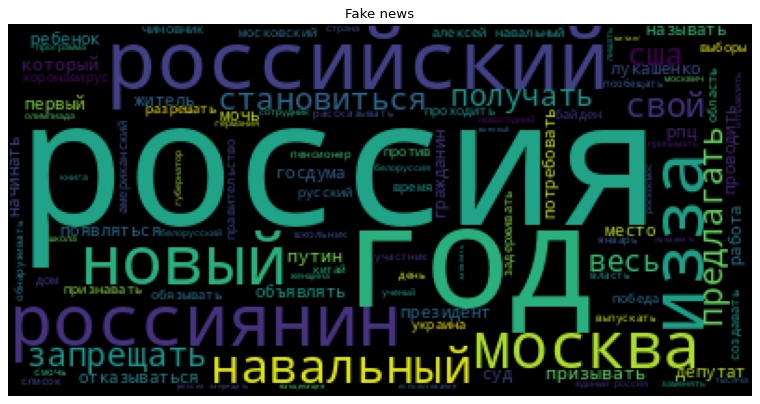

In [22]:
from visualization import generate_fakenews_wordcloud
generate_fakenews_wordcloud(clean_df, 1,'Fake news')

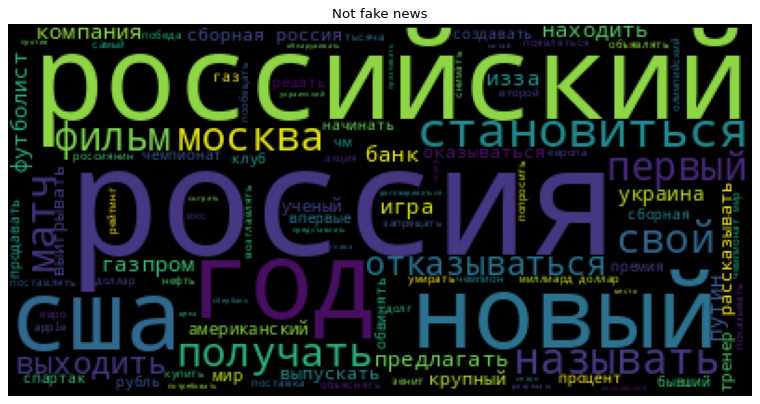

In [23]:
generate_fakenews_wordcloud(clean_df, 0,'Not fake news')

### Выводы, основанные на данных:
 * Фейки собраны с ИА "Панорама"(и иногда с ryb.ru, который перепечатывает те же статьи с указанием источника), не фейки с "Ленты.ру";
 * Фейковые заголовки, как правило длинее, чем не фейковые;
 * Категории новостей разнообразны: политика, спорт, общество, музыка, интернет, культура, наука и технологии, общество, право, экономика и так далее. Тяжело выделить наиболее популярную среди фейков категорию.

## Решение через google-запросы и проверку на источник

Так как была выяснена природа данных, то получить 100% точность можно не прибегая к моделям машинного/глубокого обучения, а просто через запросы в поисковик. Это очень лаконичное и точное решение, но направление стажировки – Data Science, поэтому для сабмита используем что-то другое.

In [52]:
from google_services import google_request

test_titles = [
    'Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы',
    'Агент Кокорина назвал езду по встречке житейской историей',
    'Госдума рассмотрит возможность введения секретных статей Уголовного кодекса',
    'ФАС заблокировала поставку скоростных трамваев для Москвы',
    'Против Навального завели дело о недоносительстве на Волкова',
    'Российским студентам запретят учиться за рубежом',
    'Путин пишет книгу об истории Украины',
    'Россияне обхитрили рост цен',
    'Звезда «Ворониных» раскрыл подробности о своем состоянии']

"""
    Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы	        1
    Агент Кокорина назвал езду по встречке житейской историей	                            0
    Госдума рассмотрит возможность введения секретных статей Уголовного кодекса	            1
    ФАС заблокировала поставку скоростных трамваев для Москвы	                            0
    Против Навального завели дело о недоносительстве на Волкова	                            1
    Российским студентам запретят учиться за рубежом	                                    1
    Путин пишет книгу об истории Украины	                                                1
    Россияне обхитрили рост цен	                                                            0
    Звезда «Ворониных» раскрыл подробности о своем состоянии	                            0
"""


google_predict = google_request(test_titles)

print('Google request predict:', google_predict)
print('Ground truth:', [1, 0, 1, 0, 1, 1, 1, 0, 0])


Google request predict: [1, 0, 1, 0, 1, 1, 1, 0, 0]
Ground truth: [1, 0, 1, 0, 1, 1, 1, 0, 0]


## Modeling

Теперь, как и требуется в задании, сделаем и обучим модель. Начнем с классического машинного обучения и для извлечения признаков из текста сделаем bag of words. 

In [53]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=2, max_df=1000)
watch_metrics = [
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
]

### Random Forest

In [26]:
from models import get_metrics_k_fold
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
metrics_rf = get_metrics_k_fold(
    clean_df['title'], clean_df['is_fake'], vectorizer, model, watch_metrics, RANDOM_STATE, FOLDS_NUMBER)
metrics_rf


,f1_score,precision_score,recall_score,accuracy_score,fold_num,model
0,0.771863,0.849372,0.707317,0.791304,0,RandomForestClassifier
1,0.777778,0.863830,0.707317,0.798261,1,RandomForestClassifier
2,0.769531,0.875556,0.686411,0.794783,2,RandomForestClassifier
3,0.772066,0.870897,0.693380,0.795652,3,RandomForestClassifier
4,0.752257,0.886525,0.653310,0.785030,4,RandomForestClassifier


### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
metrics_logreg = get_metrics_k_fold(
    clean_df['title'], clean_df['is_fake'], vectorizer, model, watch_metrics, RANDOM_STATE, FOLDS_NUMBER)
metrics_logreg


,f1_score,precision_score,recall_score,accuracy_score,fold_num,model
0,0.836625,0.862963,0.811847,0.841739,0,LogisticRegression
1,0.846831,0.855872,0.837979,0.848696,1,LogisticRegression
2,0.840659,0.886100,0.799652,0.848696,2,LogisticRegression
3,0.826401,0.859023,0.796167,0.833043,3,LogisticRegression
4,0.826291,0.896130,0.766551,0.838990,4,LogisticRegression


### Multinomial Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
metrics_nb = get_metrics_k_fold(
    clean_df['title'], clean_df['is_fake'], vectorizer, model, watch_metrics, RANDOM_STATE, FOLDS_NUMBER)
metrics_nb


,f1_score,precision_score,recall_score,accuracy_score,fold_num,model
0,0.836394,0.802885,0.872822,0.829565,0,MultinomialNB
1,0.835422,0.802568,0.871080,0.828696,1,MultinomialNB
2,0.850216,0.845095,0.855401,0.849565,2,MultinomialNB
3,0.836149,0.811475,0.862369,0.831304,3,MultinomialNB
4,0.846678,0.828333,0.865854,0.843342,4,MultinomialNB


### Passive Aggressive Classifier

In [29]:
from sklearn.linear_model import PassiveAggressiveClassifier

model = PassiveAggressiveClassifier()
metrics_pac = get_metrics_k_fold(
    clean_df['title'], clean_df['is_fake'], vectorizer, model, watch_metrics, RANDOM_STATE, FOLDS_NUMBER)
metrics_pac


,f1_score,precision_score,recall_score,accuracy_score,fold_num,model
0,0.817531,0.840074,0.796167,0.822609,0,PassiveAggressiveClassifier
1,0.815517,0.807167,0.824042,0.813913,1,PassiveAggressiveClassifier
2,0.804428,0.854902,0.759582,0.815652,2,PassiveAggressiveClassifier
3,0.800000,0.832392,0.770035,0.807826,3,PassiveAggressiveClassifier
4,0.788390,0.852227,0.733449,0.803307,4,PassiveAggressiveClassifier


Из четырех классификаторов лучше всего себя показали логрег и наивный баес. Сделаем из них ансамбль и найдем их лучшую линейную комбинацию

In [30]:
from models import EnsembleClassifier

model = EnsembleClassifier(MultinomialNB(), LogisticRegression())
ensemble_metrics = get_metrics_k_fold(
    clean_df['title'], clean_df['is_fake'], vectorizer, model, watch_metrics, RANDOM_STATE, FOLDS_NUMBER)
ensemble_metrics


,f1_score,precision_score,recall_score,accuracy_score,fold_num,model
0,0.840307,0.824121,0.857143,0.837391,0,EnsembleClassifier
1,0.841745,0.826891,0.857143,0.839130,1,EnsembleClassifier
2,0.854867,0.868705,0.841463,0.857391,2,EnsembleClassifier
3,0.847487,0.843103,0.851916,0.846957,3,EnsembleClassifier
4,0.851101,0.860963,0.841463,0.852916,4,EnsembleClassifier


Переберем с шагом в 0.05 лучшее соотношение двух классификаторов

Text(0.5, 0, 'alpha')

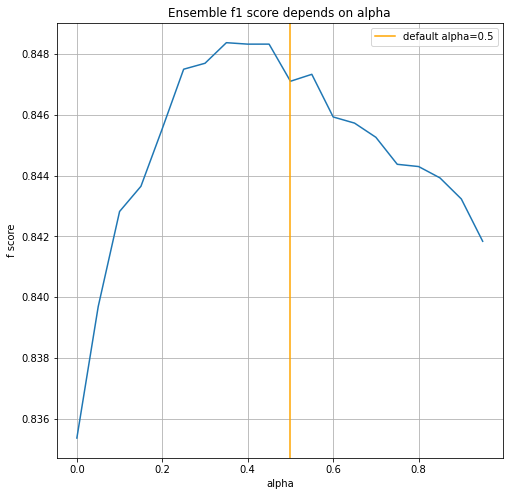

In [31]:
alphas = np.arange(0, 1, 0.05)
f_scores = []

for alpha in alphas:
    model = EnsembleClassifier(
        MultinomialNB(), LogisticRegression(), alpha=alpha)
    combine_metrics = get_metrics_k_fold(
        clean_df['title'], clean_df['is_fake'], vectorizer, model, watch_metrics, RANDOM_STATE, FOLDS_NUMBER)
    f_scores.append(combine_metrics['f1_score'].mean())

plt.figure(figsize=(8, 8))
plt.plot(alphas, f_scores)
plt.axvline(x=0.5, color='orange', label='default alpha=0.5')
plt.grid()
plt.title('Ensemble f1 score depends on alpha')
plt.legend()
plt.ylabel('f score')
plt.xlabel('alpha')


Наивысший f1 score достигается при alpha = 0.45

In [32]:
model = EnsembleClassifier(MultinomialNB(), LogisticRegression(), 0.45)
upd_ensemble_metrics = get_metrics_k_fold(clean_df['title'], clean_df['is_fake'], vectorizer, model, watch_metrics, RANDOM_STATE, FOLDS_NUMBER)
upd_ensemble_metrics

,f1_score,precision_score,recall_score,accuracy_score,fold_num,model
0,0.839760,0.826307,0.853659,0.837391,0,EnsembleClassifier
1,0.843456,0.828571,0.858885,0.840870,1,EnsembleClassifier
2,0.854610,0.870036,0.839721,0.857391,2,EnsembleClassifier
3,0.850694,0.847751,0.853659,0.850435,3,EnsembleClassifier
4,0.853097,0.866906,0.839721,0.855527,4,EnsembleClassifier


In [33]:
upd_ensemble_metrics["f1_score"].mean()

0.8483235464918796

Неплохие метрики, попробуем нейронные сети.

## LAMA
Иногда тюненные модели с очень препроцесенными данными проигрывают самому обычному AutoML, поэтому начнем с него. В ходе исследования из всех русскоязычных BERT'ов лучше всего себя показал rubert-base-cased, поэтому оставим только его.

In [35]:
train, test = train_test_split(
    clean_df, stratify=clean_df['is_fake'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

roles = {
    'text': ['title'],
    'target': 'is_fake'
}

task = Task('binary')
automl = TabularNLPAutoML(
    task=task,
    timeout=3600,
    cpu_limit=1,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'ru',
        'bert_model': 'DeepPavlov/rubert-base-cased'
    },
    nn_params={
        'opt_params': {'lr': 1e-7},
        'max_length': 256,
        'bs': 8,
        'n_epochs': 50,
    }

)

oof_pred = automl.fit_predict(train, roles=roles, verbose=10)
test_pred = automl.predict(test)

[07:52:01] Stdout logging level is DEBUG.
[07:52:01] Model language mode: ru
[07:52:01] Task: binary

[07:52:01] Start automl preset with listed constraints:
[07:52:01] - time: 3600.00 seconds
[07:52:01] - CPU: 1 cores
[07:52:01] - memory: 16 GB

[07:52:01] Train data shape: (4024, 2)

[07:52:01] Layer 1 train process start. Time left 3599.99 secs
[07:52:01] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN ...
[07:52:01] Training params: {'bs': 8, 'num_workers': 1, 'max_length': 256, 'opt_params': {'lr': 1e-07}, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'is_snap': False, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'init_bias': True, 'n_epochs': 50, 'input_bn': False, 'emb_dropout': 0.1, 'emb_ratio': 3, 'max_emb_size': 50, 'bert_name': 'DeepPavlov/rubert-base-cased', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'ru', 'deterministic': False, 'multigpu': False, 'r

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
val: 100%|██████████| 168/168 [00:22<00:00,  7.43it/s]


[07:53:47] Epoch: 0, train loss: 0.6931301951408386, val loss: 0.6930925250053406, val metric: 0.7593805525941719


val: 100%|██████████| 168/168 [00:22<00:00,  7.37it/s]


[07:55:26] Epoch: 1, train loss: 0.6930573582649231, val loss: 0.692937970161438, val metric: 0.7963308457711442


val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[07:57:06] Epoch: 2, train loss: 0.6929330229759216, val loss: 0.6927103996276855, val metric: 0.8160125710732054


val: 100%|██████████| 168/168 [00:22<00:00,  7.36it/s]


[07:58:46] Epoch: 3, train loss: 0.6927141547203064, val loss: 0.6923717260360718, val metric: 0.8176994491826581


val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[08:00:26] Epoch: 4, train loss: 0.6924733519554138, val loss: 0.6919490098953247, val metric: 0.8161125177683013


val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[08:02:06] Epoch: 5, train loss: 0.6921318769454956, val loss: 0.6914818286895752, val metric: 0.8260949715707179


val: 100%|██████████| 168/168 [00:22<00:00,  7.36it/s]


[08:03:46] Epoch: 6, train loss: 0.6915655136108398, val loss: 0.6909264326095581, val metric: 0.8210276741293533


val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[08:05:26] Epoch: 7, train loss: 0.691108226776123, val loss: 0.6903712749481201, val metric: 0.834232853589197


val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[08:07:06] Epoch: 8, train loss: 0.6906664967536926, val loss: 0.6897986531257629, val metric: 0.8376543621179815


val: 100%|██████████| 168/168 [00:22<00:00,  7.34it/s]


[08:10:25] Epoch: 10, train loss: 0.6892857551574707, val loss: 0.6884030699729919, val metric: 0.8327369847192608


val: 100%|██████████| 168/168 [00:22<00:00,  7.34it/s]


[08:12:05] Epoch: 11, train loss: 0.6886723637580872, val loss: 0.6876524686813354, val metric: 0.8364561122956646


val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[08:13:45] Epoch: 12, train loss: 0.687914252281189, val loss: 0.6868773698806763, val metric: 0.8409414978678038


train (loss=0.68728):  74%|███████▎  | 247/336 [00:56<00:20,  4.38it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[08:18:45] Epoch: 15, train loss: 0.6849971413612366, val loss: 0.6840652227401733, val metric: 0.8603777985074627


val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[08:20:25] Epoch: 16, train loss: 0.684043824672699, val loss: 0.6830105781555176, val metric: 0.8639536691542289


val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[08:22:05] Epoch: 17, train loss: 0.6832367181777954, val loss: 0.6819854378700256, val metric: 0.8675650764036957


val: 100%|██████████| 168/168 [00:22<00:00,  7.36it/s]


[08:23:45] Epoch: 18, train loss: 0.6818618774414062, val loss: 0.6808673143386841, val metric: 0.8701759061833689


val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[08:25:25] Epoch: 19, train loss: 0.6806600689888, val loss: 0.6797782182693481, val metric: 0.8747268123667378


train (loss=0.679288):  58%|█████▊    | 194/336 [00:44<00:32,  4.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[08:27:05] Epoch: 20, train loss: 0.6795006394386292, val loss: 0.6785631775856018, val metric: 0.886721526297086


val: 100%|██████████| 168/168 [00:22<00:00,  7.34it/s]


[08:30:25] Epoch: 22, train loss: 0.6768904328346252, val loss: 0.6760126948356628, val metric: 0.8930992359630419


val: 100%|██████████| 168/168 [00:22<00:00,  7.36it/s]


[08:32:05] Epoch: 23, train loss: 0.6756903529167175, val loss: 0.6747316718101501, val metric: 0.8956223347547974


val: 100%|██████████| 168/168 [00:22<00:00,  7.36it/s]


[08:33:44] Epoch: 24, train loss: 0.6742855906486511, val loss: 0.6734098792076111, val metric: 0.9010238983653162


val:  52%|█████▏    | 87/168 [00:11<00:10,  7.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

val: 100%|██████████| 168/168 [00:22<00:00,  7.35it/s]


[08:52:03] Epoch: 35, train loss: 0.6564977765083313, val loss: 0.656748354434967, val metric: 0.9146977167732766


val: 100%|██████████| 168/168 [00:22<00:00,  7.36it/s]01:11,  4.38it/s]


[08:53:43] Epoch: 36, train loss: 0.6547917723655701, val loss: 0.6550707221031189, val metric: 0.9149198205401563


val: 100%|██████████| 168/168 [00:22<00:00,  7.33it/s]


[08:55:23] Epoch: 37, train loss: 0.6530331373214722, val loss: 0.6532528400421143, val metric: 0.9153296019900498


val: 100%|██████████| 168/168 [00:22<00:00,  7.34it/s]


[08:57:03] Epoch: 38, train loss: 0.6513054966926575, val loss: 0.651491105556488, val metric: 0.9149253731343284


val: 100%|██████████| 168/168 [00:22<00:00,  7.34it/s]


[08:58:43] Epoch: 39, train loss: 0.6493245363235474, val loss: 0.6495538353919983, val metric: 0.915205223880597


train (loss=0.647156):  65%|██████▌   | 219/336 [00:50<00:26,  4.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

val: 100%|██████████| 168/168 [00:22<00:00,  7.36it/s]


[09:15:22] Epoch: 49, train loss: 0.621359646320343, val loss: 0.6228960752487183, val metric: 0.9151641346837243
[09:15:25] Time limit exceeded after calculating fold 0

[09:15:25] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN finished. score = 0.9151641346837243
[09:15:25] Lvl_0_Pipe_0_Mod_0_TorchNN fitting and predicting completed
[09:15:25] Time left -1404.25 secs

[09:15:25] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.

[09:15:25] Layer 1 training completed.

[09:15:25] Automl preset training completed in 5004.26 seconds

[09:15:25] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN) 

[09:15:25] number of text features: 1 
[09:15:25] number of categorical features: 0 
[09:15:25] number of continuous features: 0 


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
test: 100%|██████████| 216/216 [00:29<00:00,  7.38it/s]


In [36]:
predict = test_pred.data[:, 0]
predict = np.round(predict)
print(classification_report(test[roles['target']].values, predict))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       864
           1       0.88      0.87      0.87       861

    accuracy                           0.87      1725
   macro avg       0.87      0.87      0.87      1725
weighted avg       0.87      0.87      0.87      1725



## AutoML(fake-news-RoBerta)

Изучая множество подходов к решению задачи определению фейковых новостей(в основном с англоязычного соревнования на kaggle), пришла неожиданная идея. Перевести исходный датасет на английский и использовать предобученного на английских фейковых новостях BERT.

Само применение перевода и сохранение датасета я закомментировал, так как перевод занимает продолжительное время. Это связано с тем, что после каждого запроса нужно вызывать time.sleep, чтобы все 5749 запросов отправились за один раз.

In [37]:
from google_services import google_translate

translated_df = df.copy()
# translated_df['title'] = translated_df['title'].apply(google_translate)
# translated_df.to_csv('dataset/translated_df', sep='\t', index=False)
translated_df = pd.read_csv('dataset/translated_df', sep='\t')
translated_df = translated_df.loc[:, ~translated_df.columns.str.contains('^Unnamed')]
translated_df.head()

,title,is_fake
0,Muscovite Vladimir Klutin came to the interven...,1
1,Agent Kokorina called ride on the oncoming roo...,0
2,State Duma will consider the possibility of in...,1
3,FAS blocked the supply of high-speed trams for...,0
4,"Against the Navalny, the case was made about t...",1


Теперь аналогично препроцессингу русского языка, обработаем переведенный датасет

In [38]:
en_preprocess_injected = partial(preprocess_text, lang='eng')
cleaned_translated_df = translated_df.copy()
cleaned_translated_df['title'] = cleaned_translated_df['title'].apply(en_preprocess_injected)
cleaned_translated_df.to_csv('dataset/cleaned_translated_df', sep='\t', index=False)
cleaned_translated_df = pd.read_csv('dataset/cleaned_translated_df', sep='\t')
cleaned_translated_df.head()

,title,is_fake
0,muscovit vladimir klutin came intervent americ...,1
1,agent kokorina call ride oncom room everyday h...,0
2,state duma consid possibl introduc secret arti...,1
3,fa block suppli highspe tram moscow,0
4,navalni case made accuraci volkov,1


Перевели и почистили, теперь попробуем английского-фейк-ньюс BERT, притом на очищенном и неочищенном датасетах

### Переведенный и неочищенный датасет

In [39]:
train, test = train_test_split(
    translated_df, test_size=TEST_SIZE, stratify = translated_df['is_fake'], random_state=RANDOM_STATE)

roles = {
    'text': ['title'],
    'target': 'is_fake'
}

task = Task('binary')
translated_automl = TabularNLPAutoML(
    task=task,
    timeout=3600,
    cpu_limit=1,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'ghanashyamvtatti/roberta-fake-news'
    },
    nn_params={
        'opt_params': {'lr': 1e-7},
        'max_length': 256,
        'bs': 8,
        'n_epochs': 50,
    }

)

oof_pred = translated_automl.fit_predict(train, roles=roles, verbose=10)
test_pred = translated_automl.predict(test)

[09:16:05] Stdout logging level is DEBUG.
[09:16:05] Model language mode: en
[09:16:05] Task: binary

[09:16:05] Start automl preset with listed constraints:
[09:16:05] - time: 3600.00 seconds
[09:16:05] - CPU: 1 cores
[09:16:05] - memory: 16 GB

[09:16:05] Train data shape: (4030, 2)

[09:16:05] Layer 1 train process start. Time left 3599.98 secs
[09:16:05] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN ...
[09:16:05] Training params: {'bs': 8, 'num_workers': 1, 'max_length': 256, 'opt_params': {'lr': 1e-07}, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'is_snap': False, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'init_bias': True, 'n_epochs': 50, 'input_bn': False, 'emb_dropout': 0.1, 'emb_ratio': 3, 'max_emb_size': 50, 'bert_name': 'ghanashyamvtatti/roberta-fake-news', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': Fal

Some weights of the model checkpoint at ghanashyamvtatti/roberta-fake-news were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ghanashyamvtatti/roberta-fake-news and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

[09:17:48] Epoch: 0, train loss: 0.6931445002555847, val loss: 0.693136990070343, val metric: 0.703761647888322


val: 100%|██████████| 168/168 [00:22<00:00,  7.50it/s]


[09:19:23] Epoch: 1, train loss: 0.6931303143501282, val loss: 0.6930874586105347, val metric: 0.7640472204506803


val: 100%|██████████| 168/168 [00:22<00:00,  7.48it/s]


[09:20:58] Epoch: 2, train loss: 0.6930869817733765, val loss: 0.6929814219474792, val metric: 0.7870108329790251


train (loss=0.693015):  65%|██████▌   | 220/336 [00:47<00:24,  4.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

val: 100%|██████████| 168/168 [00:22<00:00,  7.50it/s]


[09:33:39] Epoch: 10, train loss: 0.6904314756393433, val loss: 0.6887680292129517, val metric: 0.8654314590419502


val: 100%|██████████| 168/168 [00:22<00:00,  7.50it/s]


[09:35:14] Epoch: 11, train loss: 0.6897100806236267, val loss: 0.6878531575202942, val metric: 0.8673325449971655


val: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]


[09:36:50] Epoch: 12, train loss: 0.6890486478805542, val loss: 0.6871131658554077, val metric: 0.8707992311507935


val: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]


[09:40:00] Epoch: 14, train loss: 0.6878081560134888, val loss: 0.6853365302085876, val metric: 0.8748117736678003


val: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]


[09:41:35] Epoch: 15, train loss: 0.6868601441383362, val loss: 0.6842101216316223, val metric: 0.8768756200396826


val: 100%|██████████| 168/168 [00:22<00:00,  7.50it/s]


[09:43:10] Epoch: 16, train loss: 0.6861345171928406, val loss: 0.6832384467124939, val metric: 0.8780448377267573


val: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]


[09:44:46] Epoch: 17, train loss: 0.6852936148643494, val loss: 0.6822656989097595, val metric: 0.8795107886904762


train (loss=0.685081):  51%|█████     | 170/336 [00:36<00:35,  4.64it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

val: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]


[09:57:27] Epoch: 25, train loss: 0.6772541999816895, val loss: 0.6738311648368835, val metric: 0.8861463205073695


val: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]01:10,  4.63it/s]


[09:59:02] Epoch: 26, train loss: 0.6766512393951416, val loss: 0.672753632068634, val metric: 0.886694391298186


val: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]


[10:00:37] Epoch: 27, train loss: 0.6750882267951965, val loss: 0.6716022491455078, val metric: 0.8876344157454648


val: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]


[10:02:12] Epoch: 28, train loss: 0.6743773221969604, val loss: 0.6704611778259277, val metric: 0.8881426268424036


val: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]


[10:03:47] Epoch: 29, train loss: 0.6731637120246887, val loss: 0.6690756678581238, val metric: 0.8887305573270976


train (loss=0.672014):  66%|██████▋   | 223/336 [00:48<00:24,  4.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

val: 100%|██████████| 168/168 [00:22<00:00,  7.50it/s]


[10:29:11] Epoch: 45, train loss: 0.6530877947807312, val loss: 0.6477317810058594, val metric: 0.8722618604733561


val: 100%|██████████| 168/168 [00:22<00:00,  7.50it/s]


[10:32:21] Epoch: 47, train loss: 0.6495604515075684, val loss: 0.6445924043655396, val metric: 0.8747209821428572


val: 100%|██████████| 168/168 [00:22<00:00,  7.49it/s]


[10:33:56] Epoch: 48, train loss: 0.647385835647583, val loss: 0.6431971192359924, val metric: 0.8679215826955783


val: 100%|██████████| 168/168 [00:22<00:00,  7.48it/s]


[10:35:31] Epoch: 49, train loss: 0.6466437578201294, val loss: 0.6419544816017151, val metric: 0.8567553323412699
[10:35:33] Time limit exceeded after calculating fold 0

[10:35:33] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN finished. score = 0.8567553323412699
[10:35:33] Lvl_0_Pipe_0_Mod_0_TorchNN fitting and predicting completed
[10:35:33] Time left -1168.60 secs

[10:35:33] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.

[10:35:33] Layer 1 training completed.

[10:35:33] Automl preset training completed in 4768.61 seconds

[10:35:33] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN) 

[10:35:33] number of text features: 1 
[10:35:33] number of categorical features: 0 
[10:35:33] number of continuous features: 0 


Some weights of the model checkpoint at ghanashyamvtatti/roberta-fake-news were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ghanashyamvtatti/roberta-fake-news and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

In [40]:
predict = test_pred.data[:, 0]
predict = np.round(predict)
print(classification_report(test[roles['target']].values, predict))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       864
           1       0.86      0.81      0.84       864

    accuracy                           0.84      1728
   macro avg       0.84      0.84      0.84      1728
weighted avg       0.84      0.84      0.84      1728



### Переведенный и очищенный датасет

In [46]:
train, test = train_test_split(
    cleaned_translated_df, test_size=TEST_SIZE, stratify = cleaned_translated_df['is_fake'], random_state=RANDOM_STATE)

roles = {
    'text': ['title'],
    'target': 'is_fake'
}

task = Task('binary')
cleaned_translated_automl = TabularNLPAutoML(
    task=task,
    timeout=3600,
    cpu_limit=1,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'ghanashyamvtatti/roberta-fake-news'
    },
    nn_params={
        'opt_params': {'lr': 1e-7},
        'max_length': 256,
        'bs': 8,
        'n_epochs': 50,
    }

)

oof_pred = cleaned_translated_automl.fit_predict(train, roles=roles, verbose=10)
test_pred = cleaned_translated_automl.predict(test)

[11:23:00] Stdout logging level is DEBUG.
[11:23:00] Model language mode: en
[11:23:00] Task: binary

[11:23:00] Start automl preset with listed constraints:
[11:23:00] - time: 3600.00 seconds
[11:23:00] - CPU: 1 cores
[11:23:00] - memory: 16 GB

[11:23:00] Train data shape: (4030, 2)

[11:23:00] Layer 1 train process start. Time left 3599.98 secs
[11:23:00] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN ...
[11:23:00] Training params: {'bs': 8, 'num_workers': 1, 'max_length': 256, 'opt_params': {'lr': 1e-07}, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'is_snap': False, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'init_bias': True, 'n_epochs': 50, 'input_bn': False, 'emb_dropout': 0.1, 'emb_ratio': 3, 'max_emb_size': 50, 'bert_name': 'ghanashyamvtatti/roberta-fake-news', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': Fal

Some weights of the model checkpoint at ghanashyamvtatti/roberta-fake-news were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ghanashyamvtatti/roberta-fake-news and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

[11:24:42] Epoch: 0, train loss: 0.6931459307670593, val loss: 0.6931427121162415, val metric: 0.5903674620890023


val: 100%|██████████| 168/168 [00:22<00:00,  7.53it/s]


[11:26:16] Epoch: 1, train loss: 0.6931397318840027, val loss: 0.6931240558624268, val metric: 0.6394668544501134


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[11:27:51] Epoch: 2, train loss: 0.6931203007698059, val loss: 0.6930732727050781, val metric: 0.6593634849773242


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:29:26] Epoch: 3, train loss: 0.6930476427078247, val loss: 0.6929543614387512, val metric: 0.6636539381377551


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:31:01] Epoch: 4, train loss: 0.692939043045044, val loss: 0.6927660703659058, val metric: 0.678136293579932


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:32:35] Epoch: 5, train loss: 0.6927578449249268, val loss: 0.6925570368766785, val metric: 0.6833136249291383


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:34:10] Epoch: 6, train loss: 0.6924761533737183, val loss: 0.6922845840454102, val metric: 0.6891065671060091


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:35:45] Epoch: 7, train loss: 0.6922412514686584, val loss: 0.6919687986373901, val metric: 0.6958450697987528


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[11:37:19] Epoch: 8, train loss: 0.6918998956680298, val loss: 0.6916353702545166, val metric: 0.7014221053004535


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[11:38:54] Epoch: 9, train loss: 0.6915276646614075, val loss: 0.6912614107131958, val metric: 0.7064477483701814


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[11:40:29] Epoch: 10, train loss: 0.6911264061927795, val loss: 0.6908815503120422, val metric: 0.709590020904195


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:42:04] Epoch: 11, train loss: 0.6908144950866699, val loss: 0.6902958750724792, val metric: 0.7168887737386621


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[11:43:39] Epoch: 12, train loss: 0.6902850866317749, val loss: 0.6897716522216797, val metric: 0.7222543314200679


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:45:14] Epoch: 13, train loss: 0.6896240711212158, val loss: 0.6892464756965637, val metric: 0.7225676729024944


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:46:48] Epoch: 14, train loss: 0.6891530156135559, val loss: 0.6884672045707703, val metric: 0.7272954754818595


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:48:23] Epoch: 15, train loss: 0.6883694529533386, val loss: 0.6875784993171692, val metric: 0.7350171839569161


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:49:58] Epoch: 16, train loss: 0.6875026226043701, val loss: 0.6864867210388184, val metric: 0.7430909863945578


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:51:33] Epoch: 17, train loss: 0.6864495277404785, val loss: 0.6854833960533142, val metric: 0.7465908889597506


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:53:07] Epoch: 18, train loss: 0.6855255961418152, val loss: 0.6842998266220093, val metric: 0.7546381182681405


val: 100%|██████████| 168/168 [00:22<00:00,  7.53it/s]


[11:54:42] Epoch: 19, train loss: 0.684536337852478, val loss: 0.6831172704696655, val metric: 0.7619335494614512


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:56:17] Epoch: 20, train loss: 0.683674156665802, val loss: 0.681926429271698, val metric: 0.7674530098497732


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[11:57:52] Epoch: 21, train loss: 0.6822783946990967, val loss: 0.6807854175567627, val metric: 0.7727831366921769


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[11:59:26] Epoch: 22, train loss: 0.6807159185409546, val loss: 0.6792576909065247, val metric: 0.776917472718254


val: 100%|██████████| 168/168 [00:22<00:00,  7.53it/s]


[12:01:01] Epoch: 23, train loss: 0.6789922118186951, val loss: 0.6779392957687378, val metric: 0.7808646896258502


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[12:02:36] Epoch: 24, train loss: 0.6785854697227478, val loss: 0.676620602607727, val metric: 0.7856899270124716


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[12:04:11] Epoch: 25, train loss: 0.6772173643112183, val loss: 0.6751355528831482, val metric: 0.7891876151502268


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[12:05:46] Epoch: 26, train loss: 0.6757542490959167, val loss: 0.6737948656082153, val metric: 0.79322230194161


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[12:07:20] Epoch: 27, train loss: 0.6739624738693237, val loss: 0.6722472906112671, val metric: 0.7972027352607709


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[12:08:55] Epoch: 28, train loss: 0.6721843481063843, val loss: 0.6706423759460449, val metric: 0.8006694214143991


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[12:10:30] Epoch: 29, train loss: 0.6715735793113708, val loss: 0.6691176295280457, val metric: 0.8041604662698413


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[12:12:05] Epoch: 30, train loss: 0.6697052717208862, val loss: 0.6678763628005981, val metric: 0.8066627692743764


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[12:13:40] Epoch: 31, train loss: 0.6684163212776184, val loss: 0.6659674048423767, val metric: 0.8096433886054423


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[12:15:14] Epoch: 32, train loss: 0.6661019325256348, val loss: 0.6643907427787781, val metric: 0.8112366691468255


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[12:16:49] Epoch: 33, train loss: 0.665492832660675, val loss: 0.6627134680747986, val metric: 0.8139892024518139


val: 100%|██████████| 168/168 [00:22<00:00,  7.53it/s]


[12:18:24] Epoch: 34, train loss: 0.6635306477546692, val loss: 0.6611087322235107, val metric: 0.8168314200680273


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[12:19:59] Epoch: 35, train loss: 0.6620135307312012, val loss: 0.6593388915061951, val metric: 0.8192241089143992


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[12:21:34] Epoch: 36, train loss: 0.6608099937438965, val loss: 0.6574408411979675, val metric: 0.8201253808815194


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[12:23:09] Epoch: 37, train loss: 0.659697949886322, val loss: 0.6563541889190674, val metric: 0.822567894345238


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[12:24:44] Epoch: 38, train loss: 0.6568087935447693, val loss: 0.6546036005020142, val metric: 0.8242907188917233


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[12:26:18] Epoch: 39, train loss: 0.6558850407600403, val loss: 0.6529884338378906, val metric: 0.8269303163973923


val: 100%|██████████| 168/168 [00:22<00:00,  7.51it/s]


[12:27:53] Epoch: 40, train loss: 0.6546982526779175, val loss: 0.6515929698944092, val metric: 0.8283176551870749


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[12:29:28] Epoch: 41, train loss: 0.6534242033958435, val loss: 0.6495230793952942, val metric: 0.8305298681972789


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]


[12:31:03] Epoch: 42, train loss: 0.6507004499435425, val loss: 0.6479431986808777, val metric: 0.8314377834467119


val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]

[12:32:37] Epoch: 43, train loss: 0.6504572629928589, val loss: 0.648148238658905, val metric: 0.8322560143849206



val: 100%|██████████| 168/168 [00:22<00:00,  7.52it/s]

[12:33:00] Early stopping: val loss: 0.6479431986808777, val metric: 0.8314377834467119


[12:33:01] Time limit exceeded after calculating fold 0

[12:33:01] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN finished. score = 0.8314377834467119
[12:33:01] Lvl_0_Pipe_0_Mod_0_TorchNN fitting and predicting completed
[12:33:01] Time left -601.54 secs

[12:33:01] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.

[12:33:01] Layer 1 training completed.

[12:33:01] Automl preset training completed in 4201.54 seconds

[12:33:01] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN) 

[12:33:01] number of text features: 1 
[12:33:01] number of categorical features: 0 
[12:33:01] number of continuous features: 0 


Some weights of the model checkpoint at ghanashyamvtatti/roberta-fake-news were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ghanashyamvtatti/roberta-fake-news and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

In [47]:
predict = test_pred.data[:, 0]
predict = np.round(predict)
print(classification_report(test[roles['target']].values, predict))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       864
           1       0.80      0.73      0.76       864

    accuracy                           0.77      1728
   macro avg       0.77      0.77      0.77      1728
weighted avg       0.77      0.77      0.77      1728



На неочищенных данных BERT лучше показал себя, поскольку внутри него есть собственные стемминг/лемматизация, декапитализация(отсутствие чувствительности к регистру) и "аттеншн". Естественно, это все больше из научного интереса, маловероятно, что переводя российские новости(со своими особенностями) на англиский язык и используя предобученного на американских новостях BERT, получится что-то хорошее. Однако когда видишь средний f1 score 0.84-0.85, уже так не думаешь.

## Лучшей моделью оказалась rubert-base-cased поэтому для сабмита используем её

In [48]:
predict = automl.predict(test_df)
predict = predict.data[:, 0]
predict = np.round(predict)
predict = predict.astype(int)
predict_column = pd.DataFrame(predict)
test_df['is_fake'] = predict_column
test_df.to_csv("~/Garipov_Timur/predictions.tsv", sep='\t', index=False)

[12:33:39] number of text features: 1 
[12:33:39] number of categorical features: 0 
[12:33:39] number of continuous features: 0 


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
test: 100%|██████████| 125/125 [00:16<00:00,  7.38it/s]


Вернем предыдущие заголовки(немного неуклюже получилось, но, к сожалению, времени на перезапуск блокнота нет)

In [51]:
test_df = pd.read_csv('dataset/test.tsv', sep='\t')
test_texts = test_df['title']
test_df['title'] = test_texts
test_df['is_fake'] = predict_column
test_df.to_csv("~/Garipov_Timur/predictions.tsv", sep='\t', index=False)

# Заключение

Помимо представленных в данном блокноте методов были использованы бустинги и LSTM, но они и близко не дали хорошего качества. В решении задачи хотелось больше углубиться в понимание данных и их тонкостей, а не заниматься перебор всех моделей и их параметров. Поэтому также были рассмотрены две статьи о российских фейковых новостях:
 * https://aclanthology.org/2020.rdsm-1.5.pdf
 * https://cyberleninka.ru/article/n/metod-opredeleniya-russkoyazychnyh-feykovyh-novostey-s-ispolzovaniem-elementov-iskusstvennogo-intellekta/viewer

Что из них важно отметить:

 1. "Для обнаружения поддельной новости необходимо в первую очередь определить общие характеристики поддельных сообщений. Среди них мы можем выделить репутацию интернет-ресурса и качество лексики языка. Репутация интернет-ресурса – это один из ключевых показателей, который может быть использован для оценки подлинности опубликованного на нем новостного материала. Самый простой способ оценки ресурса на наличие поддельной новости – это рейтинг доверия от других ресурсов и доменный возраст искомого сайта. «Сайты с длительной историей и высоким рейтингом чаще всего являются надежными источниками, в то время как обратное может указывать на ненадежный ресурс»."


 2. "В своем исследовании Г. Некрасов и И. Романова предлагают следующие характеристики в качестве модулей алгоритма: 
- проверка оригинальности URL-адреса опубликованной новости на соответствие домену искомого сайта, поскольку сайты-двойники могут целиком имитировать крупные онлайн-издания;
- проверка даты публикации материала, поскольку фейковые новости, как правило, не датированы, так как сообщают о событиях, которых не было;
- наличие грамматических и пунктуационных ошибок в тексте; проверка на наличие внутренней согласованности анализируемой статьи – поддельные новости часто имеют большую несогласованность между различными частями текста самого материала;
- поиск совпадений фрагментов разных статей –основная статья, вышедшая на авторитетном ресурсе, копируется полностью или переписывается с внесением в нее ложных фактов и событий;
- несвязанные факты в новости;
- анализ ссылок-источников в материале, поскольку есть вероятность того, что статья будет поддельной, если она ссылается также на фейковую новость;
- поиск сигнальных (сенсационных) слов - новости, которые содержат в своих заголовках и ключевых словах привлекающие внимание (сенсационные) утверждения часто могут быть фейковыми;
- неавторитетные эксперты в обсуждаемой сфере;
- несовпадение времени создания изображений и их загрузки с реальными временными рамками событий в новости."

Поэтому очень печально, что данных для обучения так мало. Я уверен, что используя информацию об источнике и содержание статьи можно достичь крайне высокой точности.


В идеале такую задачу решать с использованем внешних источников данных и ранжированными источниками новостей. В таком случае модель будет иметь более высокую точность и сможет интерпретировать результаты. Также можно было бы использовать сиамские нейронные сети, чтобы качественно разделять пары новостей: рядом, если из одного класса, поодаль, если из разных.